In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L1VzZXJzL211bGxpbnNqL0Ryb3Bib3gvVGVhY2hpbmcvRUNPTjQ1MzgvbGVjdHVyZXM="
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


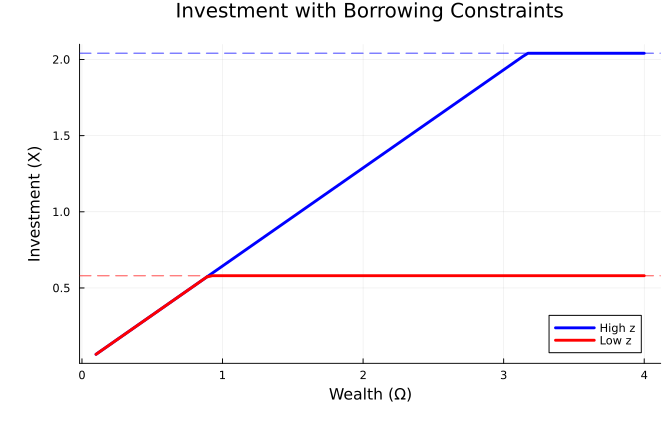

In [2]:
#| echo: false
#| output: true
using Plots

# Parameters
δ = 0.5
w = 1.0
ψ = 0.5
r = 0.05
β = 0.95

# Two ability levels
z_high = 1.5
z_low = 0.8

# Unconstrained investment for each z
X_star_high = (δ * w * z_high / (ψ * (1 + r)))^(1 / (1 - δ))
X_star_low = (δ * w * z_low / (ψ * (1 + r)))^(1 / (1 - δ))

# Wealth range
Ω_range = range(0.1, 4.0, length=100)

# Investment function with constraint
function investment(Ω, z)
    X_star = (δ * w * z / (ψ * (1 + r)))^(1 / (1 - δ))
    # When constrained (A=0): X = (β δ w z)/(ψ(1 + β δ w z)) * Ω
    X_constrained = (β * δ ) / (ψ * (1 + β * δ )) * Ω
    return min(X_constrained, X_star)
end

# Calculate investment for each wealth level and ability
X_vals_high = [investment(Ω, z_high) for Ω in Ω_range]
X_vals_low = [investment(Ω, z_low) for Ω in Ω_range]

plot(Ω_range, X_vals_high,
     xlabel="Wealth (Ω)",
     ylabel="Investment (X)",
     title="Investment with Borrowing Constraints",
     linewidth=3,
     label="High z",
     legend=:bottomright,
     grid=true,
     color=:blue,
     size=(700, 450),
     bottom_margin=8Plots.mm,
     left_margin=8Plots.mm,
     top_margin=5Plots.mm)

plot!(Ω_range, X_vals_low,
      linewidth=3,
      label="Low z",
      color=:red)

# Add horizontal lines for unconstrained optimum
hline!([X_star_high], linestyle=:dash, linewidth=1.5,
       color=:blue, label="", alpha=0.5)
hline!([X_star_low], linestyle=:dash, linewidth=1.5,
       color=:red, label="", alpha=0.5)